# Deep Drone Reinforcement Learning

Design an agent to fly a drone, and then train it using a reinforcement learning algorithm of your choice! 

We have used Sarsa, Q-learning and DDPG. But inspired by the variations of DDPG we used DDPG to train the drone. 

## Instructions

Take a look at the files in the directory to better understand the structure of the project. 

- `task.py`: Define your task (environment) in this file.
- `agents/`: Folder containing reinforcement learning agents.
    - `policy_search.py`: A sample agent has been provided here.
    - `agent.py`: Develop your agent here. we developed here DDPG, you can modify it like PPO or TRPO.
- `physics_sim.py`: This file contains the simulator for the quadcopter.  **DO NOT MODIFY THIS FILE**.

For this project, you can define your own task in `task.py`.  

You will also design different reinforcement learning agent in `agent.py` to complete your chosen task.  
s.


In [2]:
import random

class Basic_Agent():
    def __init__(self, task):
        self.task = task
    
    def act(self):
        new_thrust = random.gauss(450., 25.)
        return [new_thrust + random.gauss(0., 1.) for x in range(4)]

Run the code cell below to have the agent select actions to control the drone.  

Feel free to change the provided values of `runtime`, `init_pose`, `init_velocities`, and `init_angle_velocities` below to change the starting conditions of the drone.

The `labels` list below annotates statistics that are saved while running the simulation.  All of this information is saved in a text file `data.txt` and stored in the dictionary `results`.  

In [3]:
%load_ext autoreload
%autoreload 2

import csv
import numpy as np
from tasks.base_task import Task

# Modify the values below to give the quadcopter a different starting position.
runtime = 5.                                     # time limit of the episode
init_pose = np.array([0., 0., 10., 0., 0., 0.])  # initial pose
init_velocities = np.array([0., 0., 0.])         # initial velocities
init_angle_velocities = np.array([0., 0., 0.])   # initial angle velocities
file_output = 'data.txt'                         # file name for saved results

# Setup
task = Task(init_pose, init_velocities, init_angle_velocities, runtime)
agent = Basic_Agent(task)
done = False
labels = ['time', 'x', 'y', 'z', 'phi', 'theta', 'psi', 'x_velocity',
          'y_velocity', 'z_velocity', 'phi_velocity', 'theta_velocity',
          'psi_velocity', 'rotor_speed1', 'rotor_speed2', 'rotor_speed3', 'rotor_speed4']
results = {x : [] for x in labels}

# Run the simulation, and save the results.
with open(file_output, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(labels)
    while True:
        rotor_speeds = agent.act()
        _, _, done = task.step(rotor_speeds)
        to_write = [task.sim.time] + list(task.sim.pose) + list(task.sim.v) + list(task.sim.angular_v) + list(rotor_speeds)
        for ii in range(len(labels)):
            results[labels[ii]].append(to_write[ii])
        writer.writerow(to_write)
        if done:
            break

Run the code cell below to visualize how the position of the drone evolved during the simulation.

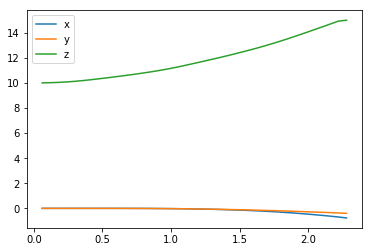

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results['time'], results['x'], label='x')
plt.plot(results['time'], results['y'], label='y')
plt.plot(results['time'], results['z'], label='z')
plt.legend()
_ = plt.ylim()

The next code cell visualizes the velocity of the drone.

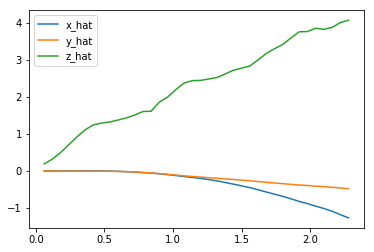

In [5]:
plt.plot(results['time'], results['x_velocity'], label='x_hat')
plt.plot(results['time'], results['y_velocity'], label='y_hat')
plt.plot(results['time'], results['z_velocity'], label='z_hat')
plt.legend()
_ = plt.ylim()

Next, you can plot the Euler angles (the rotation of the drone over the $x$-, $y$-, and $z$-axes),

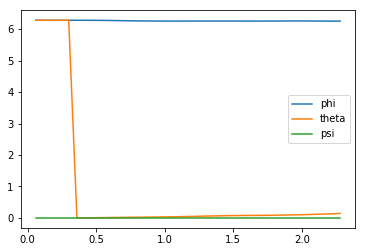

In [6]:
plt.plot(results['time'], results['phi'], label='phi')
plt.plot(results['time'], results['theta'], label='theta')
plt.plot(results['time'], results['psi'], label='psi')
plt.legend()
_ = plt.ylim()

before plotting the velocities (in radians per second) corresponding to each of the Euler angles.

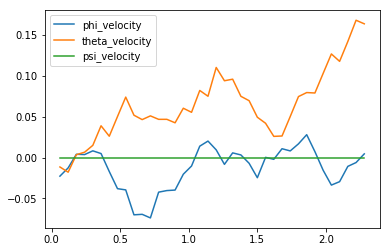

In [7]:
plt.plot(results['time'], results['phi_velocity'], label='phi_velocity')
plt.plot(results['time'], results['theta_velocity'], label='theta_velocity')
plt.plot(results['time'], results['psi_velocity'], label='psi_velocity')
plt.legend()
_ = plt.ylim()

Finally, you can use the code cell below to print the agent's choice of actions.  

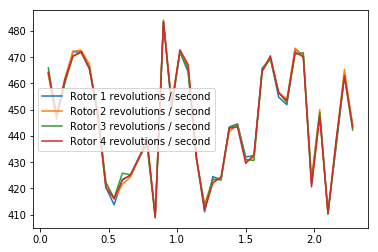

In [8]:
plt.plot(results['time'], results['rotor_speed1'], label='Rotor 1 revolutions / second')
plt.plot(results['time'], results['rotor_speed2'], label='Rotor 2 revolutions / second')
plt.plot(results['time'], results['rotor_speed3'], label='Rotor 3 revolutions / second')
plt.plot(results['time'], results['rotor_speed4'], label='Rotor 4 revolutions / second')
plt.legend()
_ = plt.ylim()

When specifying a task, you will derive the environment state from the simulator.  Run the code cell below to print the values of the following variables at the end of the simulation:
- `task.sim.pose` (the position of the drone in ($x,y,z$) dimensions and the Euler angles),
- `task.sim.v` (the velocity of the drone in ($x,y,z$) dimensions), and
- `task.sim.angular_v` (radians/second for each of the three Euler angles).

In [9]:
# the pose, velocity, and angular velocity of the drone at the end of the episode
print(task.sim.pose)
print(task.sim.v)
print(task.sim.angular_v)

[-0.76159199 -0.39583263 15.          6.25521245  0.14154246  0.        ]
[-1.26953805 -0.47872507  4.07771581]
[0.00449113 0.16387469 0.        ]


## The Agent

The sample agent given in `agents/policy_search.py` uses a very simplistic linear policy to directly compute the action vector as a dot product of the state vector and a matrix of weights. Then, it randomly perturbs the parameters by adding some Gaussian noise, to produce a different policy. Based on the average reward obtained in each episode (`score`), it keeps track of the best set of parameters found so far, how the score is changing, and accordingly tweaks a scaling factor to widen or tighten the noise.

Run the code cell below to see how the agent performs on the sample task.

In [10]:
import sys
import pandas as pd
from agents.policy_search import PolicySearch_Agent
from tasks.base_task import Task

num_episodes = 50
target_pos = np.array([0., 0., 10.])
task = Task(target_pos=target_pos)
agent = PolicySearch_Agent(task) 

for i_episode in range(1, num_episodes+1):
    state = agent.reset_episode() # start a new episode
    while True:
        action = agent.act(state) 
        next_state, reward, done = task.step(action)
        agent.step(reward, done)
        state = next_state
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f} (best = {:7.3f}), noise_scale = {}".format(
                i_episode, agent.score, agent.best_score, agent.noise_scale), end="")  # [debug]
            break
    sys.stdout.flush()

Episode =   34, score =  -6.000 (best =  -6.000), noise_scale = 3.25

C:\Users\hp\Desktop\Quadrotor\test55\quadcopter-project\physics_sim.py:114: RuntimeWarning: invalid value encountered in double_scalars
  J = V / n * D
C:\Users\hp\Desktop\Quadrotor\test55\quadcopter-project\physics_sim.py:114: RuntimeWarning: divide by zero encountered in double_scalars
  J = V / n * D


Episode =   50, score =  -6.000 (best =  -6.000), noise_scale = 3.2

This agent should perform very poorly on this task.  And that's where you come in!

## Define the Task, Design the Agent, and Train Your Agent!

Amend `task.py` to specify a task of your choosing.  If you're unsure what kind of task to specify, you may like to teach your drone to takeoff, hover in place, land softly, or reach a target pose.  

After specifying your task, use the sample agent in `agents/policy_search.py` as a template to define your own agent in `agents/agent.py`.  You can borrow whatever you need from the sample agent, including ideas on how you might modularize your code (using helper methods like `act()`, `learn()`, `reset_episode()`, etc.).

Note that it is **highly unlikely** that the first agent and task that you specify will learn well.  You will likely have to tweak various hyperparameters and the reward function for your task until you arrive at reasonably good behavior.

As you develop your agent, it's important to keep an eye on how it's performing. Use the code above as inspiration to build in a mechanism to log/save the total rewards obtained in each episode to file.  If the episode rewards are gradually increasing, this is an indication that your agent is learning.

In [ ]:
## TODO: Train your agent here
import os
import pickle
from agents.agent import DDPG_Agent
from tasks.task import Task
#from tasks.task import Task

exportPath = './data/'
if not os.path.exists(exportPath):
    os.makedirs(exportPath)

# z axis is up
init_pose = np.array([0.0, 0.0, 1.0, 0.0, 0.0, 0.0]) 
target_pos = np.array([0.0, 0.0, 10.0])
task = Task(init_pose=init_pose, target_pos=target_pos, runtime=5.0)
#agent = PolicySearch_Agent(task) 
#agent = Basic_Agent(task) 
agent = DDPG_Agent(task)

# before training
resultsAll = []
high_score = -1000000.0
low_score = 1000000.0

# number of episodes to train
num_episodes = 750

training_results = {
    'score': [],
    }

for i_episode in range(1, num_episodes+1):
    # start a new episode
    state = agent.reset_episode() 
    score = 0

    episode_results = {
        'time': [],
        'x': [],
        'y': [],
        'z': [],
        'phi': [],
        'theta': [],
        'psi': [],
        'vx': [],
        'vy': [],
        'vz': [],
        'reward': [],
        }

    while True:
        action = agent.act(state)  
        next_state, reward, done = task.step(action)

        agent.step(action, reward, next_state, done)
        state = next_state
        score += reward
        high_score = max(high_score, score)
        low_score = min(low_score, score)

        # track the results for offline analysis
        episode_results['time'].append(task.sim.time)
        episode_results['x'].append(state[0])
        episode_results['y'].append(state[1])
        episode_results['z'].append(state[2])
        episode_results['phi'].append(state[3])
        episode_results['theta'].append(state[4])
        episode_results['psi'].append(state[5])
        episode_results['vx'].append(state[6])
        episode_results['vy'].append(state[7])
        episode_results['vz'].append(state[8])
        episode_results['reward'].append(reward)
        
        if done:
            print("\rEpisode = {:4d}, score = {:7.3f}, low score = {:7.3f}, high score = {:7.3f}".format(i_episode, score, low_score, high_score), end="")
            training_results['score'].append(score)
            break

    resultsAll.append(episode_results)

    sys.stdout.flush()

# save results for later analysis
with open("{}results0.bin".format(exportPath), 'wb') as pickleFile:
    pickle.dump(resultsAll, pickleFile)

Using TensorFlow backend.


Episode =  726, score =  21.271, low score =   1.664, high score =  90.058

## Plot the Rewards

Once you are satisfied with your performance, plot the episode rewards, either from a single run, or averaged over multiple runs. 

In [ ]:
## plot rewards over all episodes
import pandas as pd

plt.plot(training_results['score'], label='reward')
plt.legend()
_ = plt.ylim()

df = pd.DataFrame(training_results['score'])
p1 = df.rolling(window=25).mean().plot(legend=False)

In [ ]:
## Render top result
with open('data/results0.bin', 'rb') as pickleFile:
    results = pickle.load(pickleFile)

# Sort wrt episode reward
episodeRewards = [np.sum(r['reward']) for r in results]
resultIndices = np.argsort(episodeRewards)

# Get top results
resultIndices = list(reversed(resultIndices))[0:1]

In [ ]:
# Plot reward for top result
for iE, e in enumerate(resultIndices):
    res = results[e]
    
    # plot reward
    plt.plot(res['time'], res['reward'], label='reward')
    plt.legend()
    _ = plt.ylim()
    

In [ ]:
# Plot position for top result
for iE, e in enumerate(resultIndices):
    res = results[e]   
    
    plt.plot(res['time'], res['x'], label='x')
    plt.plot(res['time'], res['y'], label='y')
    plt.plot(res['time'], res['z'], label='z')
    plt.legend()
    _ = plt.ylim()

In [ ]:
# Plot angular velocity for top result
for iE, e in enumerate(resultIndices):
    res = results[e]   
    
    plt.plot(res['time'], res['phi'], label='phi')
    plt.plot(res['time'], res['theta'], label='theta')
    plt.plot(res['time'], res['psi'], label='psi')
    plt.legend()
    _ = plt.ylim()

In [ ]:
# Plot velocity for top result
for iE, e in enumerate(resultIndices):
    res = results[e]   
    
    plt.plot(res['time'], res['vx'], label='vx')
    plt.plot(res['time'], res['vy'], label='vy')
    plt.plot(res['time'], res['vz'], label='vz')
    plt.legend()
    _ = plt.ylim()

In [ ]:
## Generate visualisation
from visualise import Quadrotor
from IPython.display import Image
import os
import imageio

exportPath = './video/'
if not os.path.exists(exportPath):
    os.makedirs(exportPath)
        
images = []

for iE, e in enumerate(resultIndices):
    res = results[e] 
   
    filepath = "{}frame{:10}_{:10}.png".format(exportPath, iE, 0)
    
    q = Quadrotor(x=res['x'][0], 
            y=res['y'][0], 
            z=res['z'][0], 
            roll=res['phi'][0],
            pitch=res['theta'][0], 
            yaw=res['psi'][0],
            reward=res['reward'][0], 
            title=None,
            filepath=filepath)
    
    q.set_target(0.0, 0.0, 10.0)
    
    # Render all frames in this episode
    for i in range(1, len(res['x'])):
        filepath = "{}frame{:10}_{:10}.png".format(exportPath, iE, i)
        
        q.update_pose(x=res['x'][i], 
        y=res['y'][i], 
        z=res['z'][i], 
        roll=res['phi'][i],
        pitch=res['theta'][i], 
        yaw=res['psi'][i],
        reward=res['reward'][i],
        title=None,
        filepath=filepath)
        
        images.append(imageio.imread(filepath))
        
    q.close()   
    
# Save all frames to animated gif
imageio.mimsave("movie.gif", images)

# Render animated gif
with open('./movie.gif','rb') as f:
    display(Image(data=f.read(), format='png'))

## Task
The task specified was to take off from (0, 0, 1) and fly to a point (0, 0, 10) and loiter. The reward function consisted of the following:

- penalty based on distance$^2$ from target to encourage the quadcopter to fly toward target
- penalty based on angular deviation to encourage the quadcopter to remain upright

The following parameters were experimented with but not used in the final reward function:

- reward for time to encourage quadcopter to remain in the air
- penalty based on movement in the xy plane to encourage the quadcopter to fly vertically
- penalty for high velocity to encourage quadcopter to fly slower
- reward for quadcopter remaining close to target to encourage loitering

The final reward function was equivalent to the following:
``` python
dist_from_target_squared = np.square(self.sim.pose[:3] - self.target_pos).sum()
angular_deviation = np.sqrt(np.square(self.sim.pose[3:]).sum())
reward = 1.0 - (0.004 * dist_from_target_squared + 0.008 * angular_deviation)
```


The algorithm used for learning was Deep Deterministic Policy Gradients (DDPG) as described in the [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971) paper. The choice was based on the requirement to support learning in a continuous action space.

The implementation was based on source code provided in the project classroom but modified to use the neural network architecture defined in the original paper. The state space was also extended to include velocity in addition to pose. 

After many iterations of parameter tuning without any significant progress I switched from a tanh activation to a sigmoid activation in the final layer of the actor network which immediately boosted the networks ability to learn.

In general the agent learned to take and fly to the target but become unstable when loitering for any length of time. Small changes to the weights used in the reward function would have large impacts on the agents ability to fly the task.

### Hyperparameters*
Initial hyperparameters based on the [Continuous control with deep reinforcement learning](https://arxiv.org/abs/1509.02971) paper. The primary difference was the use of a sigmoid activation in final layer of the actor network rather than tanh.

- Actor learning rate = 0.0001 
- Critic learning rate = 0.001 
- Discount factor $\gamma$ = 0.99
- Soft targets $\tau$ = 0.001
- Minibatch size = 64
- Replay buffer size = 1000000
- Exploration Noise Process = Ornstein-Uhlenbeck ($\theta$ = 0.15, $\alpha$ = 0.2)

### Actor Neural Network Architecture*

The actor architecture used two hidden layers of 400 and 300 respectively both with weight regularization and relu activation. Batch normalisation was also used after each hidden layer.

The final output layer used a sigmoid activation with weights initialised to Uniform $[-3e-3, 3e-3]$. The output was then scaled to the action dimension $[0-1]$

### Critic Neural Network Architecture*

The critic architecture used two hidden layers of 400 and 300 respectively both with l2 weight regularization and relu activation. Batch normalisation was also used after each hidden layer.

The action tensor was combined in the 2nd hidden layer using a relu activation.

The final output layer connected to one output representing Q values with weights initialised to Uniform $[-3e-3, 3e-3]$.





Some of the attempts to improve the learning included:
- Disbaling l2 weight regularization in both actor and critic networks
- Disabling random weights initialization in actor final output layer
- The use of sigmoid vs tanh activation functions
- Increasing actor learnign rate by factor 10
- Increasing critic learning rate by factor 10
- Increasing number of episodes - 500, 1000, 1500, 2000
- Increasing penalties by factor 10
- Decreasing penalties by factor 10
- Increased exploration noise volatility $\sigma$ from 0.2 to 0.3
- Clamping reward to $[-1,1]$
- Clamping reward to $[-1,1]$ using tanh
- Using a non-linear funciton for reward such as distance$^2$ and angular_deviation$^2$
- Simplifying the reward function


In [ ]:
print("Mean rewards over the last 10 episodes: {}".format(np.sum(training_results['score'][-10:])/10))